In [1]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import graphing # custom graphing code. See our GitHub repo for details

#Import the data from the .csv file
dataset = pandas.read_csv('sf_crime.csv', delimiter="\t")

# One-hot encode features
dataset = pandas.get_dummies(dataset, columns=["Category", "PdDistrict"], drop_first=False)

features = [c for c in dataset.columns if c != "Resolution"]

# Make a utility method that we can re-use throughout this exercise
# To easily fit and test out model
def fit_and_test_model(model):
    '''
    Trains a model and tests it against both train and test sets
    '''  
    global features

    # Train the model
    model.fit(train[features], train.Resolution)

    # Assess its performance
    # -- Train
    predictions = model.predict(train[features])
    train_accuracy = balanced_accuracy_score(train.Resolution, predictions)

    # -- Test
    predictions = model.predict(test[features])
    test_accuracy = balanced_accuracy_score(test.Resolution, predictions)

    return train_accuracy, test_accuracy


print("Ready!")
dataset.head()

Ready!


,DayOfWeek,Resolution,X,Y,day_of_year,time_in_hours,Category_ARSON,Category_ASSAULT,Category_BAD CHECKS,Category_BRIBERY,...,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
0,5,True,-122.403405,37.775421,29,11.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,5,True,-122.403405,37.775421,29,11.000000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,True,-122.388856,37.729981,116,14.983333,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,2,False,-122.412971,37.785788,5,23.833333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,False,-122.419672,37.765050,1,0.500000,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [2]:
# Split the dataset in an 90/10 train/test ratio. 
train, test = train_test_split(dataset, test_size=0.1, random_state=2, shuffle=True)

## Criteria to split on

The first hyperparameter we will work with is the criterion. This is essentially a kind of cost function that is used to determine whether a node should be split or not. We have two options available in the package that we are using: `gini` and `entropy`. Let's try them both: 

In [3]:
from sklearn.ensemble import RandomForestClassifier
import plotly.io as pio
pio.renderers.default = "svg"

# Shrink the training set temporarily to explore this
# setting with a more normal sample size
sample_size = 1000
full_trainset = train
train = full_trainset[:sample_size]


# Prepare the model 
rf = RandomForestClassifier(n_estimators=10,
                            # max_depth=12,
                            # max_features=cur_max_features,
                            random_state=2,
                            criterion="gini", 
                            verbose=False)
# Train and test the result
train_accuracy, test_accuracy = fit_and_test_model(rf)
# Train and test the result
print(train_accuracy, test_accuracy)

# Prepare the model 
rf = RandomForestClassifier(n_estimators=10,
                            random_state=2,
                            criterion="entropy", 
                            verbose=False)
# Train and test the result
train_accuracy, test_accuracy = fit_and_test_model(rf)
# Train and test the result
print(train_accuracy, test_accuracy)

# Roll back the train dataset to the full train set
train = full_trainset


0.9719390319921176 0.6842617724903477
0.9701142144738695 0.6912451859737102


Results are subtly different, and usually only subtly as both criterion use a similar way to assess performance. We suggest you try different sample sizes, such as 50 and 50000, to see how this changes with larger or smaller samples. 

## Minimum impurity decrease

The minimum impurity decrease is another criterion that is used to assess whether a node should be split. It is used by the `gini` or `entropy` algorithms we used, above. If minimu impurity decrease is high, then splitting  a node must result in substantial performance improvement. If it is very low, then nodes can be split even if they offer very little to no performance improvements on the training dataset. 

Working...


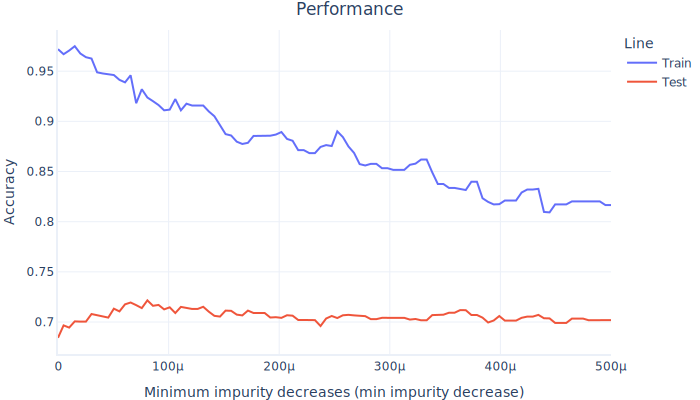

In [4]:
import numpy as np

# Shrink the training set temporarily to explore this
# setting with a more normal sample size
full_trainset = train
train = full_trainset[:1000] # limit to 1000 samples

min_impurity_decreases = np.linspace(0, 0.0005, num=100)

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

print("Working...")
for min_impurity_decrease in min_impurity_decreases:

    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=10,
                                min_impurity_decrease=min_impurity_decrease,
                                random_state=2, 
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_and_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)


# Plot results
graphing.line_2D(dict(Train=train_accuracies, Test=test_accuracies), 
                    min_impurity_decreases,
                    label_x="Minimum impurity decreases (min_impurity_decrease)",
                    label_y="Accuracy",
                    title="Performance", show=True)

# Roll back the train dataset to the full train set
train = full_trainset


Notice that _train_ performance drastically reduces as we get more scrict about when a node can be split. This is because the higher the minimum impurity decrease, the more strict we are about growing our tree. The smaller the tree, the less overfitting we will see.

Changes in _test_ performance are more subtle. A small increase above zero appears to increase test performance. Further increases begin to hurt test performance only subtly. 

This is similar to what we saw in the previous exercise about model size - more complex models (those with more nodes) can fit the training data better, but once they exceed a certain complexity, they begin to overfit.


## Maximum number of features

When trees are created, they are provided with a subset of the data. This not only means they see a certain collection of rows (samples), but also a certain collection of columns (features). The more features are provided, the more likely a given tree is going to overfit. Let's see what happens when we restrict the maximum number of features that can be provided to each tree in the forest:

Working...


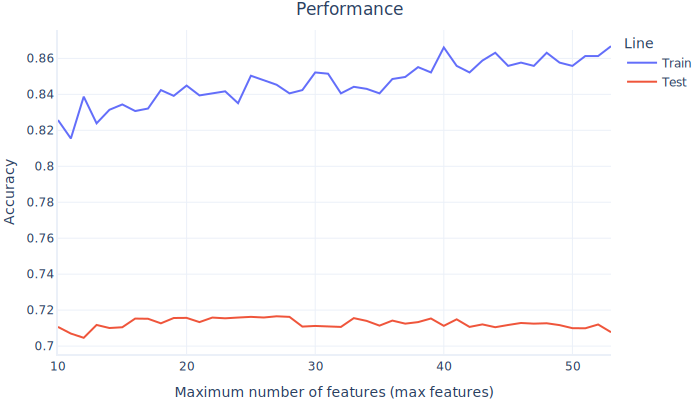

In [5]:
# Shrink the training set temporarily to explore this
# setting with a more normal sample size
full_trainset = train
train = full_trainset[:1000] # limit to 1000 samples

max_features = range(10, len(features) +1)

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

print("Working...")
for cur_max_features in max_features:
    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=50,
                                max_depth=12,
                                max_features=cur_max_features,
                                random_state=2, 
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_and_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)


# Plot results
graphing.line_2D(dict(Train=train_accuracies, Test=test_accuracies), 
                    max_features,
                    label_x="Maximum number of features (max_features)",
                    label_y="Accuracy",
                    title="Performance", show=True)

# Roll back the trainset to the full set
train = full_trainset

The more features we have, the worse the overfitting (gap between blue and red lines). Initial increases from 10 - 20 provide a minute improvement in test performance, after which it begins to hurt test performance very slightly. As features increase, training performance continues to grow, unmatches by test performance, indicating overfitting. An optimal value here would be around 20 features.

## Seeding

Finally, we come to seeding. When trees are initially made, there is a degree of randomness that is used to decide which features and samples will be provided to which trees. Changing the random state (seed) value changes this initial state.

The random seed is not a parameter to be tuned, but its effects on our models shouldn't be forgotten, particularly when there isn't much data to work with. Let's see how our model behaves with different random states.

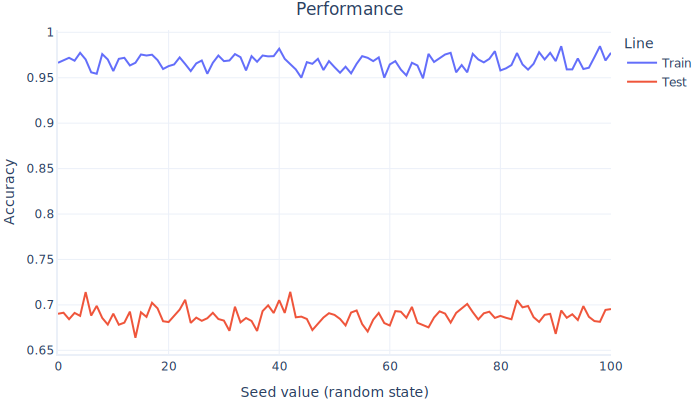

In [6]:
# Shrink the training set temporarily to explore this
# setting with a more normal sample size
sample_size = 1000
full_trainset = train
train = full_trainset[:sample_size] 


seeds = range(0,101)

# Train our models and report their performance
train_accuracies = []
test_accuracies = []

for seed in seeds:
    # Prepare the model 
    rf = RandomForestClassifier(n_estimators=10,
                                random_state=seed, 
                                verbose=False)
    
    # Train and test the result
    train_accuracy, test_accuracy = fit_and_test_model(rf)

    # Save the results
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)


# Plot results
graphing.line_2D(dict(Train=train_accuracies, Test=test_accuracies), 
                    seeds,
                    label_x="Seed value (random_state)",
                    label_y="Accuracy",
                    title="Performance", show=True)

# Roll back the trainset to the full set
train = full_trainset

Performance, particularly on the test set, is variable and thus some part of performance is blind luck. This is not only because the initial state of the model can be different, but also that we split our training and test data differently. Whether this would apply to a holdout set is not easy to tell without trying it 

There's no correlation between high or low seed values and performance: seed is not something to 'tune'. The seed is a random factor and it can help or hinder depending on the model at play. Generally speaking, when we work with small amounts of data, we are more likely to be affected by different seed values. More complex models can also be affected more by the seed, but not always.

Try changing the sample size and/or number of trees in the model above and watch how the variability in performance changes. Think about why this might be.

## Summary

Complex models typically have associated hyperparameters that can affect training. The extent to which these matter, and how they affect the result, depends on the data at hand and complexity of the model being used. We usually need to experiment somewhat with these in order to achieve optimum performance for the data that we have.